# TTA

In [1]:
from fastai2.vision.all import *

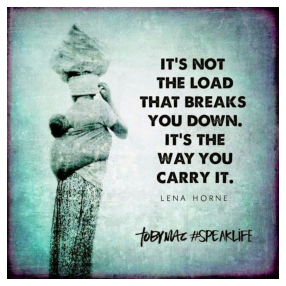

In [2]:
img = PILImage.create('foundations/images/l.jpg')
img.show();

In [11]:
img.shape

(564, 564)

In [19]:
rows, columns = img.shape

We want to create the image to square of the size provided in each of the four corners together with a center crop to perform TTA

**Center crop**

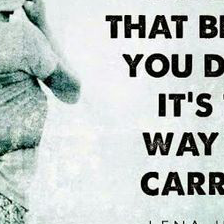

In [8]:
c_crop = img.crop_pad(224)
c_crop

In [18]:
c_crop.shape

(224, 224)

**Upper left corner**

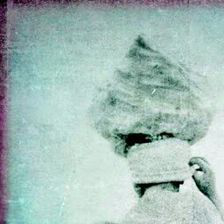

In [15]:
ul_crop = img.crop((0,0,224,224))
ul_crop

In [16]:
ul_crop.shape

(224, 224)

**Upper right corner**

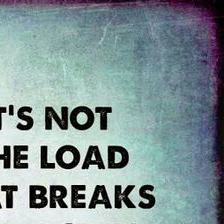

In [21]:
ur_crop = img.crop((340, 0, 564, 224))
ur_crop

In [22]:
ur_crop.shape

(224, 224)

**Lower left corner**

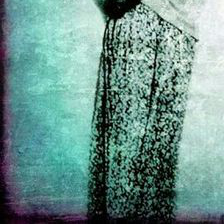

In [23]:
ll_crop = img.crop((0, 340, 224, 564))
ll_crop

In [24]:
ll_crop.shape

(224, 224)

**Lower right crop**

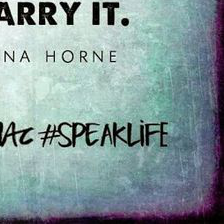

In [25]:
lr_crop = img.crop((340, 340, 564, 564))
lr_crop

In [26]:
lr_crop.shape

(224, 224)

**Combine and display corner crops**

In [37]:
corner_crops = [ul_crop, ur_crop, ll_crop, lr_crop]

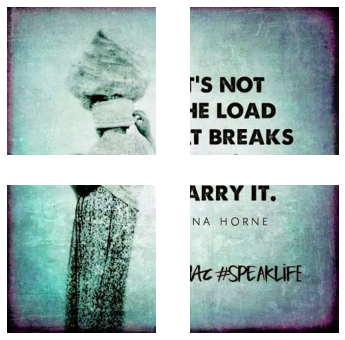

In [38]:
fig, axs = plt.subplots(2,2, figsize=(6,6))

for o, ax in zip(corner_crops, axs.flatten()):
    show_image(o, ax)

**Define generic function to extract crops for any image**

In [40]:
def crops_tta(img, size):
    h, w = img.shape
    c = img.crop_pad(size)
    ul = img.crop((0, 0, 0+size, 0+size))
    ur = img.crop((w-size, 0, w, size))
    ll = img.crop((0, h-size, size, h))
    lr = img.crop((w-size, h-size, w, h))
    return c, ul, ur, ll, lr

In [41]:
crops = crops_tta(img, 224)

Let's check if the same images were returned

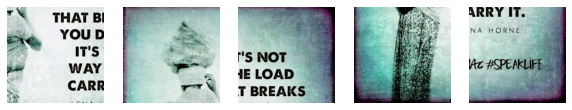

In [44]:
fig, axs = plt.subplots(1,5, figsize=(10,10))

for o, ax in zip(crops, axs.flatten()):
    show_image(o, ax)

## Data 

In [7]:
path = untar_data(URLs.PETS)
Path.BASE_PATH = path
path.ls()

(#2) [Path('images'),Path('annotations')]

In [8]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller('(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [9]:
dls = dblock.dataloaders(path/'images')

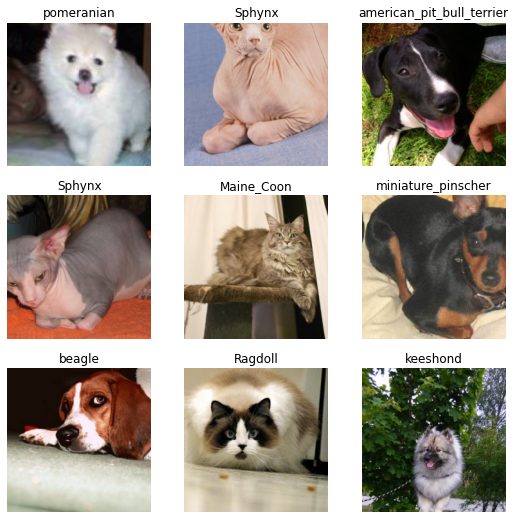

In [10]:
dls.show_batch()

## Create Learner

In [11]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

In [12]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.521821,0.341118,0.110284,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.496724,0.310354,0.092693,00:31
1,0.392383,0.315408,0.094046,00:31
2,0.272757,0.267628,0.081867,00:32
3,0.182576,0.262983,0.077131,00:32
4,0.120428,0.248473,0.071042,00:32


## TTA function

In [14]:
learn.dls.train.after_batch

Pipeline: IntToFloatTensor -> AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm -> Normalize

In [15]:
learn.dls.valid.after_batch

Pipeline: IntToFloatTensor -> AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm -> Normalize

In [2]:
class UpperLeft(Transform):
    def __init__(self, size):
        self.size = size
    
    def encodes(self, img:TensorImage):
        _, _, h, w = img.shape
        return img.crop((0, 0, 0+size, 0+size))

In [3]:
class UpperRight(Transform):
    def __init__(self, size):
        self.size = size
    
    def encodes(self, img:TensorImage):
        _, _, h, w = img.shape
        return img.crop((w-size, 0, w, size))

In [4]:
class LowerLeft(Transform):
    def __init__(self, size):
        self.size = size
    
    def encodes(self, img:TensorImage):
        _, _, h, w = img.shape
        return img.crop((0, h-size, size, h))

In [5]:
class LowerRight(Transform):
    def __init__(self, size):
        self.size = size
    
    def encodes(self, img:TensorImage):
        _, _, h, w = img.shape
        return img.crop((w-size, h-size, w, h))

In [ ]:
def tta(learn, dl, size):
    tfms = [UpperLeft(size), UpperRight(size), LowerLeft(size), LowerRight(size)]
    preds = []
    # get predictions for default approach on validation sets that uses the center crop
    preds.append(learn.get_preds())
    for tfm in tfms:
        dl = dl.new(after_batch=Pipeline([IntToFloatTensor, tfm]))
        preds.append(learn.get_preds(dl=dl))

In [16]:
learn.fit??

In [17]:
learn._do_epoch_validate??

In [18]:
learn.get_preds??